# ESTUDIO AOI E IRRADIANCIA DE UNA LENTE BICONVEXA. 

Importamos las librerias

In [1]:
from pvlib import irradiance
from pvlib import location
import pandas as pd
import matplotlib.pyplot as plt
import math as m
from scipy.integrate import quad 

Definimos las caracteristicas del módulo fotovoltaico: inclinaciones, tamaño y distancia focal

In [2]:
caracteristics_module={    
    'tilt':30,
    'surface_azimuth':180,
    'focal_distance': 5,
    'tam_module':7,
    'radius_multijunction':2,
    'radius_spot':2.001
    }

Definimos las caracteristicas de la localización.

In [3]:
caracteristics_ETSIDI_summer={
    'lat':40.405655,
    'lon':-3.700292,
    'tz':'Etc/GMT+2',
    'date':'21-06-2020',
    'temp':60
    }

Con estos datos de localización podemos crear un objeto con la función location de pvlib. 

In [4]:
site = location.Location(caracteristics_ETSIDI_summer['lat'], 
                         caracteristics_ETSIDI_summer['lon'],
                        caracteristics_ETSIDI_summer['tz'])

Creamos con panda una lista de tiempos a lo largo de un día teniendo enceunta el tz de la localización creada. 

In [5]:
times = pd.date_range(caracteristics_ETSIDI_summer['date'], freq='10min', periods=6*24,
                      tz=site.tz)

Con esta lista times, podemos obtener los datos clearsky. esta funcion get_clearsky nos devuelve un dataframe con el dni, ghi y dhi.  Con la funcion get_solarposition obtenemos un dataframe con el zenith y el azimuth

In [6]:
clearsky = site.get_clearsky(times)
solar_position = site.get_solarposition(times)

Con estos datos, podemos usar la funcion get_total_irradiance y calcular la irradiancia total que nos devuelve el poa directo, difuso y global

In [7]:
total_irrad=irradiance.get_total_irradiance( 
    surface_tilt=caracteristics_module['tilt'],
    surface_azimuth=caracteristics_module['surface_azimuth'],
    dni=clearsky['dni'],
    ghi=clearsky['ghi'],
    dhi=clearsky['dhi'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'])

Tambien podemos sacar el AOI de esta localización. Sacamos el máximo y mínimo presente. 

In [8]:
AOI=irradiance.aoi( caracteristics_module['tilt'],
                   caracteristics_module['surface_azimuth'],
                   solar_position['apparent_zenith'], 
                   solar_position['azimuth'])
min_AOI=min(AOI)
max_AOI=max(AOI)

Definimos una función que calcula el máximo AOIaprovechable dentro del rango de movimiento de la célula. Para ello se usa la función que relaciona el tamaño del modulo, el AOI y la distancia focal. 

In [9]:
def get_max_aoi(tam_module,focal_dist):
    MAX_AOI=m.atan(tam_module/focal_dist)*180/m.pi
    return MAX_AOI
MAX_AOI=get_max_aoi(caracteristics_module['tam_module'],caracteristics_module['focal_distance'])

# REPARTO DE IRRADIANCIA

Creamos dos listas para poder considerar qué irradiancia será usada para iluminación y cual para electricidad. 

La lista light=[] Recogerá toda la irradiancia que será utilizada para iluminación. Se va a considerar que capta la irradiancia directa que llega con un AOI mayor que el máximo recién calculado y la difusa. 

La lista electricity=[] . Recogerá toda la irradiancia directa dentro del AOI máximo. Consideramos que la celula tiene un tracking interno que seguiría los rayos con esos AOI.

In [10]:
light=[]
electricity=[]

In [11]:
for x in range(len(AOI)):    
    if AOI[x]>MAX_AOI:
        light.append(total_irrad['poa_direct'][x])
        electricity.append(0)
        AOI[x]=MAX_AOI
    else:
        electricity.append(total_irrad['poa_direct'][x])
        light.append(0)

for i in range(len(light)):
    light[i]=light[i]+total_irrad['poa_diffuse'][i]

Simplemente por criterio, cambiamos el signo del AOI. 

In [12]:
for x in range(len(AOI)):
    if AOI[x]==min_AOI:
        a=x
        for x in range(a,len(AOI)):
          AOI[x]=-AOI[x]

Dibujamos:

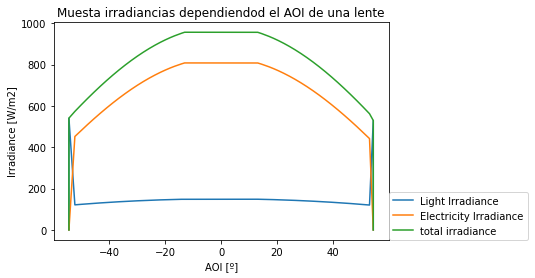

<Figure size 432x288 with 0 Axes>

In [13]:
plt.plot(AOI,light, label='Light Irradiance')
plt.plot(AOI,electricity, label='Electricity Irradiance')
plt.plot(AOI,total_irrad['poa_global'],label='total irradiance')
"plt.plot(AOI,total_irrad['poa_diffuse'],label='diffuse')"
plt.legend(loc=(1.0, 0))
plt.xlabel('AOI [º]')
plt.ylabel('Irradiance [W/m2]')
plt.title('Muesta irradiancias dependiendod el AOI de una lente')
plt.show()
plt.gcf().set_tight_layout(True)

# X DESPLAZADO DEL SPOT RESPECTO EL FOCO DE LA LENTE  DEPENDIENDO DEL AOI

Definimos una función, que basada en la relación que hay entre el aoi, el spot y la distancia focal. La distancia focal será la distancia que hay entre la lente y el módulo fotovoltaico

In [14]:
def get_r(AOI,focal_dist):
    r=focal_dist*m.tan(AOI*m.pi/180)
    "por el convenio establecido:"
    r=-r
    return r

In [15]:
R=[]
for i in AOI:
    R.append(get_r(i,caracteristics_module['focal_distance']))

Dibujamos:

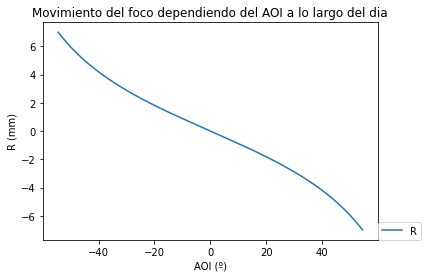

<Figure size 432x288 with 0 Axes>

In [16]:
plt.plot(AOI,R,label='R')
"plt.plot(AOI,X,label='X')"
"plt.plot(AOI,Y,label='Y')"
plt.legend(loc=(1.0, 0))
plt.xlabel('AOI (º)')
plt.ylabel('R (mm)')
plt.title('Movimiento del foco dependiendo del AOI a lo largo del dia')
plt.show()
plt.gcf().set_tight_layout(True)

# ESTUDIO TENIENDO EN CUENTA EL CONCEPTO DE SPOT

Creamos otras dos listas que recogerán la irradiancia destinada a iluminación (light_spot) y la destinada a electricidad (electricity_spot)

In [17]:
light_spot=[]
electricity_spot=[]

Trabajamos teniendo en cuenta la intersección de dos circulos: el circulo del spot y el circulo de la celula de multiunión. El circulo del spot es algo mayor. Se plantea la siguiente integral matemática. R es el desplazamiento del foco, Rs el radio del spot, Rm el radio de la celula multiunión. Usamos los puntos C, A, B para poder determinar los limites de integración

<img src="SPOT_Integral.png">

In [19]:
def f(x):
    return m.sqrt(abs((caracteristics_module['radius_multijunction'])**2-x**2))

In [20]:
def intersection(f,d, rs, rm):
    B=rm
    C=abs(d)-rs
    A=(B+C)/2
    match_surface=quad(f,A,B)
  
    if match_surface[0]<0:
        match_surface_ = 0 
          
    else:
        match_surface_=4*match_surface[0]
    return match_surface_

Se especifica dentro de la funcion intersection que si el resultado de la integral es negativo es porque no hay ningun área común. 

Definimos dos listas, para poder tratar mejor los datos. Uno que recoja las superficies comunes entre el spot y la celula (match_surface) y otro que recoja la eficiencia eléctrica obtenida(electric_efficiency). 

In [21]:
match_surface=[]
electric_efficiency=[]

La eficiencia eléctrica se va a calcular tenieno en cuenta la relación de áreas. Sin asumir pérdidas se va a dividir así el poa directo entre la irradiancia para generación de electricidad y la lumínica. Obviamente se considera que si la superficie de contacto es nula, toda la electricidad será de aprovechamiento lumínico

In [22]:
for i in range(len(R)):
   match_surface.append(intersection(f,R[i],caracteristics_module['radius_spot'],caracteristics_module['radius_multijunction']))
   
   if match_surface==0:
        light_spot.append(total_irrad['poa_direct'][i])
        electricity_spot.append(0)
      
    
   else:
        electric_efficiency.append(match_surface[i]/(m.pi*(caracteristics_module['radius_spot'])**2))
        light_spot.append(total_irrad['poa_direct'][i]*(1-electric_efficiency[i]))
        electricity_spot.append(total_irrad['poa_direct'][i]*electric_efficiency[i])

  

 Volvemos a achacar toda la irradiancia difusa a la irradiancia de aprovechamiento lumínico.

In [23]:
for i in range(len(light)):
    light_spot[i]=light_spot[i]+total_irrad['poa_diffuse'][i]


Dibujamos la eficiencia de generación eléctrica (proporcional al área coincidente)

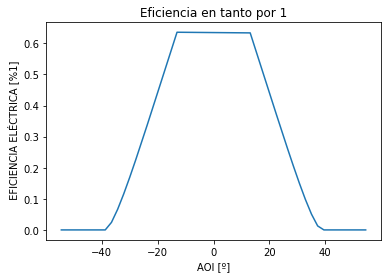

In [24]:
plt.plot(AOI, electric_efficiency,label='eficiencia generación electrica')
plt.xlabel('AOI [º]')
plt.ylabel(' EFICIENCIA ELÉCTRICA [%1]')
plt.title('Eficiencia en tanto por 1')
plt.show()





Dibujamos las irradiancias obtenidas para generación electrica e iluminación

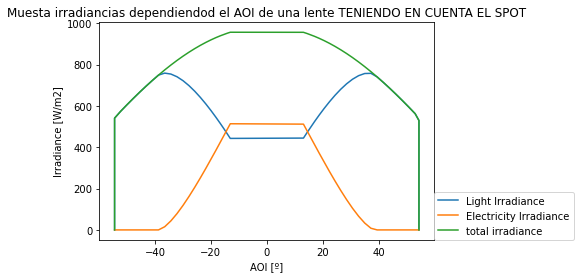

<Figure size 432x288 with 0 Axes>

In [25]:
plt.plot(AOI,light_spot, label='Light Irradiance')
plt.plot(AOI,electricity_spot, label='Electricity Irradiance')
plt.plot(AOI,total_irrad['poa_global'],label='total irradiance')
"plt.plot(AOI,total_irrad['poa_diffuse'],label='diffuse')"
plt.legend(loc=(1.0, 0))
plt.xlabel('AOI [º]')
plt.ylabel('Irradiance [W/m2]')
plt.title('Muesta irradiancias dependiendod el AOI de una lente TENIENDO EN CUENTA EL SPOT')
plt.show()
plt.gcf().set_tight_layout(True)